In [7]:
import fixed_income_derivatives_E2024 as fid
from numpy.linalg import solve, inv
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, root_scalar, minimize_scalar
from scipy.stats import norm, ncx2, gamma
import copy
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import seaborn as sns

In [55]:
# 2b) 
# Zero-Coupon Bond Price
def zero_coupon_bond_price(r0,a,b,sigma,T):
    M = len(T)
    p = np.zeros([M])
    for i in range(0,M):
        B = (1/a)*(1-np.exp(-a*T[i]))
        A = (B-T[i])*(a*b-0.5*sigma**2)/(a**2)-(sigma**2*B**2)/(4*a)
        p[i] = np.exp(A-r0*B)
    return p

# Spot Rate
def spot_rate(r0,a,b,sigma,T):
    M = len(T)
    r = np.zeros([M])
    for i in range(0,M):
        B = (1/a)*(1-np.exp(-a*T[i]))
        A = (B-T[i])*(a*b-0.5*sigma**2)/(a**2)-(sigma**2*B)/(4*a)
        if T[i] < 1e-6:
            r[i] = r0
        else:
            r[i] = (-A+r0*B)/T[i]
    return r

# Forward Rate
# Forward Rate
def forward_rate(r0, a, b, sigma, T):
    M = len(T)
    f = np.zeros([M])
    for i in range(0, M):
        B = (1 / a) * (1 - np.exp(-a * T[i]))
        B_T = np.exp(-a * T[i])
        if T[i] < 1e-6:
            f[i] = r0
        else:
            f[i] = (1 - B_T) * (a * b - 0.5 * sigma**2) / (a**2) + (sigma**2 * B * B_T) / (2 * a) + r0 * B_T
    return f



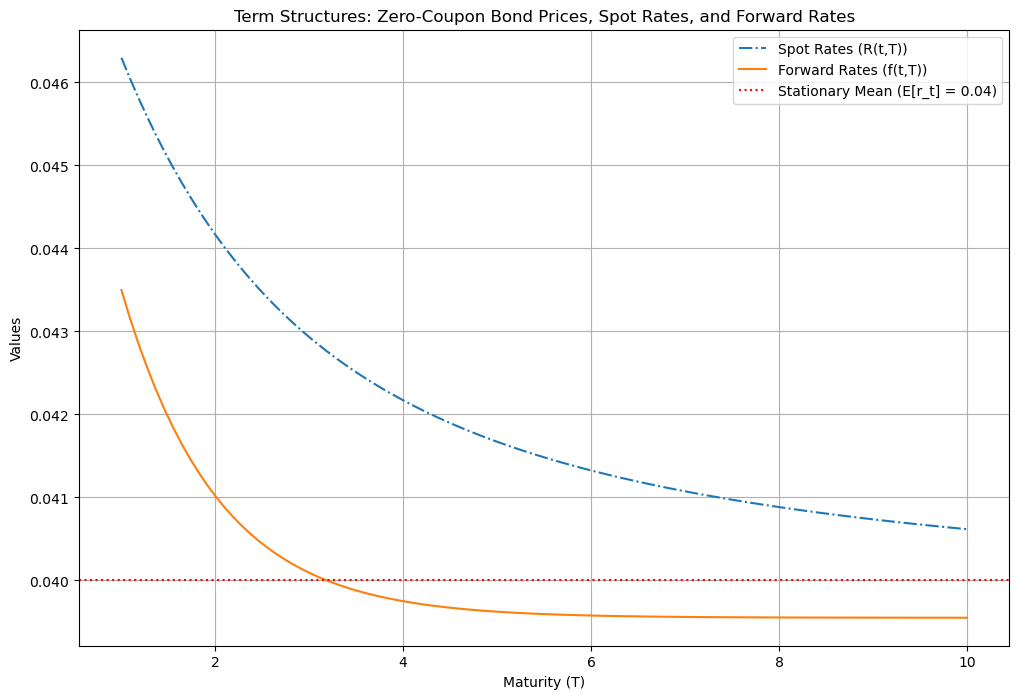

In [62]:
# 2c) 

# Parameters
a = 1.0
b = 0.04
sigma = 0.03
r0 = 0.05
T_values = np.linspace(1, 10, 100)


p = zero_coupon_bond_price(r0, a, b, sigma, T_values) 
R = spot_rate(r0, a, b, sigma, T_values) 
f = forward_rate(r0, a, b, sigma, T_values) 

# Combined Plot
plt.figure(figsize=(12, 8))

# plt.plot(T_values, p_values, label="Zero-Coupon Bond Prices (p(t,T))", linestyle='--')
plt.plot(T_values, R, label="Spot Rates (R(t,T))", linestyle='-.')
plt.plot(T_values, f, label="Forward Rates (f(t,T))", linestyle='-')

# Add stationary mean
stationary_mean = b / a  # E[r_t] = b / a
plt.axhline(y=stationary_mean, color='red', linestyle=':', label=f"Stationary Mean (E[r_t] = {stationary_mean:.2f})")

# Customizing plot
plt.title("Term Structures: Zero-Coupon Bond Prices, Spot Rates, and Forward Rates")
plt.xlabel("Maturity (T)")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()




In [67]:
# 3b) 

def zcb_cir(r0,a,b,sigma,T):
    M = len(T)
    p = np.zeros([M])
    for i in range(0,M):
        gamma = np.sqrt(a**2+2*sigma**2)
        D = (gamma+a)*(np.exp(gamma*T[i])-1)+2*gamma
        A = ((2*gamma*np.exp(0.5*T[i]*(a+gamma)))/D)**((2*a*b)/(sigma**2))
        B = 2*(np.exp(gamma*T[i])-1)/D
        p[i] = A*np.exp(-r0*B)
    return p

def spot_cir(r0,a,b,sigma,T):
    M = len(T)
    r = np.zeros([M])
    for i in range(0,M):
        if T[i] < 1e-6:
            r[i] = r0
        else:
            gamma = np.sqrt(a**2+2*sigma**2)
            D = (gamma+a)*(np.exp(gamma*T[i])-1)+2*gamma
            A = ((2*gamma*np.exp(0.5*T[i]*(a+gamma)))/D)**((2*a*b)/(sigma**2))
            B = 2*(np.exp(gamma*T[i])-1)/D
            r[i] = (-np.log(A)+r0*B)/(T[i])
    return r

def forward_cir(r0,a,b,sigma,T): 
    N = len(T)
    f = np.zeros([N])
    for i in range(0,N):
        if T[i] < 1e-6:
            f[i] = r0
        else:
            c = (2*a*b)/(sigma**2)
            gamma = np.sqrt(a**2+2*sigma**2)
            N = 2*gamma*np.exp(0.5*T[i]*(a+gamma))
            N_T = gamma*(gamma+a)*np.exp(0.5*T[i]*(a+gamma))
            D = (gamma+a)*(np.exp(gamma*T[i])-1)+2*gamma
            D_T = gamma*(a+gamma)*np.exp(gamma*T[i])
            M = 2*(np.exp(gamma*T[i])-1)
            M_T = 2*gamma*np.exp(gamma*T[i])
            f[i] = c*(-N_T/N+D_T/D)+r0*(M_T*D-M*D_T)/D**2
    return f

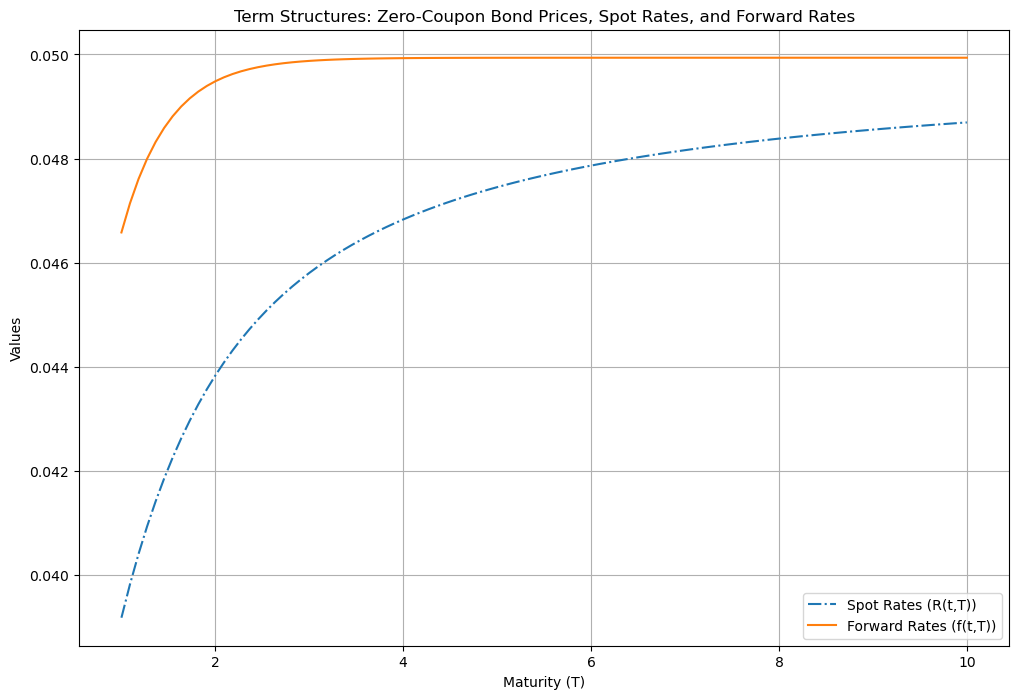

In [68]:
# 2c)

#Params 
a_cir = 2
b_cir = 0.05
sigma_cir = 0.1
r0_cir = 0.025
T_values = np.linspace(1, 10, 100)

p_cir = zcb_cir(r0_cir, a_cir, b_cir, sigma_cir, T_values) 
R_cir = spot_cir(r0_cir, a_cir, b_cir, sigma_cir, T_values)
f_cir = forward_cir(r0_cir, a_cir, b_cir, sigma_cir, T_values) 

# Combined Plot
plt.figure(figsize=(12, 8))

# plt.plot(T_values, p_values, label="Zero-Coupon Bond Prices (p(t,T))", linestyle='--')
plt.plot(T_values, R_cir, label="Spot Rates (R(t,T))", linestyle='-.')
plt.plot(T_values, f_cir, label="Forward Rates (f(t,T))", linestyle='-')

# Add stationary mean
# stationary_mean = b / a  # E[r_t] = b / a
# plt.axhline(y=stationary_mean, color='red', linestyle=':', label=f"Stationary Mean (E[r_t] = {stationary_mean:.2f})")

# Customizing plot
plt.title("Term Structures: Zero-Coupon Bond Prices, Spot Rates, and Forward Rates")
plt.xlabel("Maturity (T)")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()